# Investigate A Dataset: Titanic Data Analysis


### Introduction

The purpose of this project is to perform analysis on a dataset containing demographic and passenger information of the RMS Titanic and to find likely factors that affect a passenger's chance in surviving the sinking ship. More information regarding the dataset can be found at https://www.kaggle.com/c/titanic.

#### Data Dictionary

Taken from https://www.kaggle.com/c/titanic/data.


Variable      | Definition                                | Key
------------- | ------------------------------------------|------------------------------------------------
survival      | Survival                                  | 0 = No, 1 = Yes
pclass        | Ticket Class                              | 1 = 1st, 2 = 2nd, 3 = 3rd
sex           | Sex                                       |
Age           | Age in years                              |
sibsp         | # of siblings/spouses aboard the Titanic  |
parch         | # of parents/children aboard the Titanic  |
ticket        | Ticket number                             |
fare          | Passanger fare                            |
cabin         | Cabin number                              |
embarked      | Port of Embarkation                       | C = Cherbourg, Q = Queenstown, S = Southampton

Notes:
* pclass is aproxy for socio-economic status (SES) 
o 1st = Upper
o 2nd = Middle
o 3rd = Lower
* Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5
* sibsp defines sibling (brother, sister, stepbrother, stepsister) and spouse (husband, wife)
* parch defines parent (mother, father) and child (daughter, son, stepdaughter, stepson)
* Some children travelled only with a nanny, therefore parch=0 for them.


# Question

The main question that I want to answer is which characteristics of a Titanic passenger affect the passenger's chance of survival.  

To answer that question, I've decided to focus on few characteristics that I'll explore using questions below:
1. Did female passanger have a better chance of survival than male?
2. Did socio-economic status count as a factor in survival rate?  
3. Did traveling alone (without family members: parents, spouse, children, or siblings) give a passanger a better chance at survival?
4. Did children (18 year-old or younger) have a better chance of survival? 

# Data Wrangling

## Data Acquisition

The dataset was provided in a csv file format as part of project material.  

Now let's set up IPython Notebook by importing all necessary modules. We'll also need to set matplotlib to render plots inline for better viewing.  

In [222]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# set matplotlib to render plots inline
%matplotlib inline

Now let read the dataset and store it into a Pandas DataFrame

In [223]:
# read and store CSV dataset into pandas dataframe
titanic_df = pd.read_csv('titanic-data.csv')

Now let's see what we have.

In [224]:
# display dataframe info
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Notice that we have 891 entries in the data set and it looks like most columns have complete entries and only 3 columns have some missing values. Those columns with missing values are Age, Cabin, and Embark, with most missing values appear in Cabin. It does also look like all people in the dataset were passengers (not crew members) of the Titanic because they all paid fare and got a ticket. This is important to note because we just want to see survival chance of passengers and not of crew members. Therefore, we don't want to have crew data in our dataset that can lead to misinterpretation.

Now let's see the first and last few entries in the dataset.

In [225]:
# display first few records to review data format and value
titanic_df.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [226]:
# display last few records to review data format and value
titanic_df.tail(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


Notice that some values are indeed missing (NaN) for Age, which can be problematic when we try to answer question # 4. Some values are also missing for Cabin, though this one won't be a problem since we wouldn't need Cabin data to answer those questions mentioned above. 

Some columns are not relevant to our questions (i.e. PassangerId, Name, Ticket, Fare, Cabin and Embarked), and we better remove them to unclutter the data. Some other columns are not direct subjects of our investigation (i.e. SibSp and Parch). We need to manipulate those columns to directly represent a variable that we want to investigate. 

To answer question # 3, we need to know whether a passanger was traveling alone (without family members) but we don't have a column showing that information. However, we can easily get it from column SibSp and Parch. If SibSp + Parch is zero, then the passanger must traveling alone. It is worth to take a note here that a stepchild as well as a stepsibling counted as family members.

Now, let's start cleaning the dataset.

## Data Cleaning

Here's what we're going to do:
1. Check for and remove duplicates.
2. Remove unnecessary columns.
3. Convert SibSp and Parch columns into Talone (traveling alone) column, remove unnecessary columns.
4. Check for incorrect and missing values, and map data values when necessary.

So let's roll.

#### 1. Removing Duplicate Entry

In [227]:
# display the number of duplicate entries
print "Number of duplicate entry = {}".format(titanic_df.duplicated().sum())

Number of duplicate entry = 0


We don't have any duplicate entry. Great, now let's move on

#### 2. Removing Unnecessary Columns

In [228]:
# create new dataframe with unnecesssary columns removed
cleaned_titanic_df = titanic_df.drop(["PassengerId", "Name", "Ticket", "Fare", "Cabin", "Embarked"], axis=1)

# view new dataframe
cleaned_titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


#### 3. Converting SibSp and Parch into Talone

What I want to do here is to have a column named Talone that has a value of either 1 (traveled alone) or 0 (not traveled alone). First I'll create a column that take a value from the sum of SibSp and Parch values. Then, I'll convert the sum to reflect that if it is 0 then the passenger was traveling alone, otherwise the passenger was not traveling alone.

In [229]:
# add a column named Talone,to reflect the number of familiy member traveling with the passenger
cleaned_titanic_df['Talone'] = cleaned_titanic_df.SibSp + cleaned_titanic_df.Parch

# display first few entries
cleaned_titanic_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Talone
0,0,3,male,22.0,1,0,1
1,1,1,female,38.0,1,0,1
2,1,3,female,26.0,0,0,0
3,1,1,female,35.0,1,0,1
4,0,3,male,35.0,0,0,0
5,0,3,male,NaN,0,0,0
6,0,1,male,54.0,0,0,0
7,0,3,male,2.0,3,1,4
8,1,3,female,27.0,0,2,2
9,1,2,female,14.0,1,0,1


I'm going to use a lambda function to convert each value of Talone into False or True. Then, check for missing and incorrect values to make sure that I've converted all values correctly.

In [230]:
# update Talone values by applying a lambda function
cleaned_titanic_df['Talone'] = cleaned_titanic_df.Talone.apply(lambda x: False if x > 0 else True)

# check whether the update produce any missing values
sum_Talone_missing = cleaned_titanic_df.Talone.isnull().sum()

# check whether the update produce any incorrect values
sum_Talone_incorrect = len(cleaned_titanic_df.Talone)-cleaned_titanic_df.Talone.isin([0,1]).sum()

print "Number of missing values for Talone column = {}".format(sum_Talone_missing)
print "Number of incorrect values for Talone column = {}".format(sum_Talone_incorrect)

Number of missing values for Talone column = 0
Number of incorrect values for Talone column = 0


Nice, we have all values correct for Talone column. Now we can remove SibSp, and Parch columns since we don't need them anymore.

In [231]:
# remove unnecessary columns
cleaned_titanic_df = cleaned_titanic_df.drop(["SibSp", "Parch"], axis=1)

# display first few entries
cleaned_titanic_df.head(n=10)

,Survived,Pclass,Sex,Age,Talone
0,0,3,male,22.0,False
1,1,1,female,38.0,False
2,1,3,female,26.0,True
3,1,1,female,35.0,False
4,0,3,male,35.0,True
5,0,3,male,NaN,True
6,0,1,male,54.0,True
7,0,3,male,2.0,False
8,1,3,female,27.0,False
9,1,2,female,14.0,False


#### 4. Checking For Incorrect and Missing Values

To save ourselves from typing repetitive codes, let's define a few helper functions

In [232]:
# draw bar graph for the input column
def cleaned_titanic_bargraph(col_name):
    """
    Args:
        col_name: column to use
    """
    # plot the bar graph
    g = cleaned_titanic_df.groupby([col_name]).size().plot(kind='bar', rot =0)
    
    # set the title
    g.axes.set_title('{} Distribution of Titanic Passanger in Dataset'.format(col_name))
    
    # set the y label
    g.axes.set_ylabel('No. of Passengers')

# display the distribution of data in a column
def cleaned_titanic_dist(col_name):
    """
    Args:
        col_name: column to use
    Returns:
        pandas dataframe consists of count and percentage of each value in the column
    """
    
    # display missing values
    print 'Number of missing values: {}'.format(cleaned_titanic_df[col_name].isnull().sum())
    
    # values count
    count = cleaned_titanic_df.groupby([col_name]).size() 
    
    # values percentage
    percentage = count.groupby(level=0).apply(lambda x: (100*x/count.sum()).round(1))
    
    # store in a panda dataframe
    df = pd.DataFrame(data={col_name:count.keys(),'count':count, 'percentage':percentage})
    
    return df.set_index(col_name)

##### Survived

Since Survived column currently takes 0 for non-survivors and 1 for survival, then we will change the value to False and True respectively, for better interpretation of data values.

In [233]:
# update Survived values to True or False
cleaned_titanic_df['Survived'] = cleaned_titanic_df.Survived.apply(lambda x: False if x == 0 else True)

Number of missing values: 0


,count,percentage
Survived,,
False,549,61.6
True,342,38.4


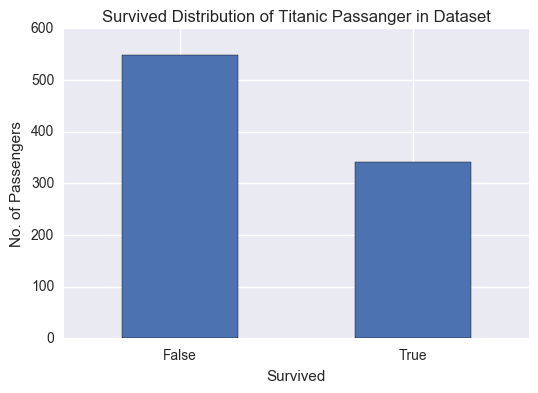

In [234]:
cleaned_titanic_bargraph('Survived')
cleaned_titanic_dist('Survived')

There's no incorrect and no missing values in Survived column. The numbers show that only 38.4% passangers in the dataset survived the tragedy.

##### Pclass

Number of missing values: 0


,count,percentage
Pclass,,
1,216,24.2
2,184,20.7
3,491,55.1


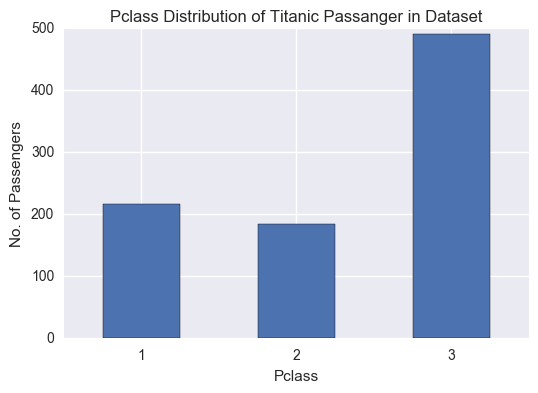

In [235]:
cleaned_titanic_bargraph('Pclass')
cleaned_titanic_dist('Pclass')

There's no incorrect and no missing values in Pclass column. The numbers show that most passengers (55.1%) in the dataset were from 3rd class.

##### Sex

Number of missing values: 0


,count,percentage
Sex,,
female,314,35.2
male,577,64.8


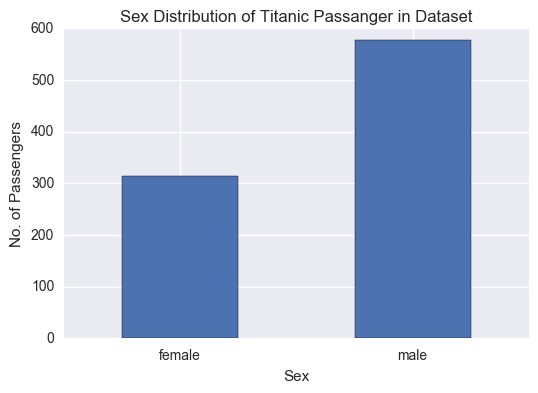

In [236]:
cleaned_titanic_bargraph('Sex')
cleaned_titanic_dist('Sex')

There's no incorrect and no missing values in Sex column. The numbers show that most passengers in the dataset (64.8%) are males, and only 35.2% of them are females.

##### Age

Since we're going to need the data grouped base on age (children and adult), then we better do it now.

In [237]:
# add a column 
cleaned_titanic_df['AgeGroup'] = cleaned_titanic_df.Age.apply(lambda x: None if pd.isnull(x) else "Child" if x <=18 else "Adult")
 
cleaned_titanic_df.head(n=10)

,Survived,Pclass,Sex,Age,Talone,AgeGroup
0,False,3,male,22.0,False,Adult
1,True,1,female,38.0,False,Adult
2,True,3,female,26.0,True,Adult
3,True,1,female,35.0,False,Adult
4,False,3,male,35.0,True,Adult
5,False,3,male,NaN,True,None
6,False,1,male,54.0,True,Adult
7,False,3,male,2.0,False,Child
8,True,3,female,27.0,False,Adult
9,True,2,female,14.0,False,Child


Now let's see the Age distribution of passengers in the dataset.

Number of missing values: 177


,Age
count,714.000000
mean,29.699118
std,14.526497
min,0.420000
25%,20.125000
50%,28.000000
75%,38.000000
max,80.000000


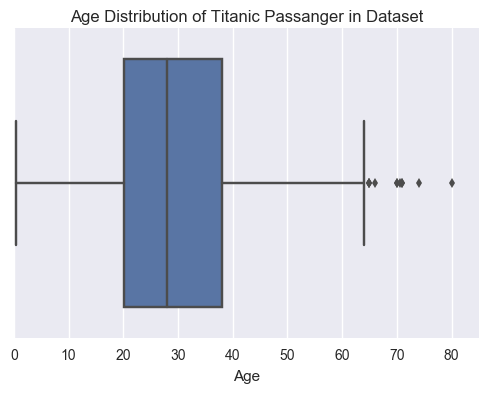

In [238]:
print 'Number of missing values: {}'.format(cleaned_titanic_df.Age.isnull().sum())

# draw histogram subplot for Age
g = sns.boxplot(cleaned_titanic_df[cleaned_titanic_df.Age.notnull()].Age)
g.axes.set_title('Age Distribution of Titanic Passanger in Dataset')
g.axes.set_xlim([0,85])

pd.DataFrame(cleaned_titanic_df.Age.describe())

As we've already known, there are 177 missing values in Age column which represent roughly 20% total records in the dataset. We can consider to remove these entries, and proceed with less data. However, that's might not be necessary since we won't be focusing our analysis in Age category alone. I decided to keep these missing values and made a note that they were there. 

Notice that for the 714 passengers in the dataset with available age values, the youngest passenger was 0.42 year old, and the oldest passenger was 80 years-old. Therefore, we can be sure that all age values are in a reasonable range.

Also notice that we have a positively skewed (mean=29.7, median=28), with interquartile range between 20.1 and 38. We can see from the boxplot that there are quite a few positive outliers, though I'm not going to do anything to them since they represent valid values. 

Now let see age distribution across gender.

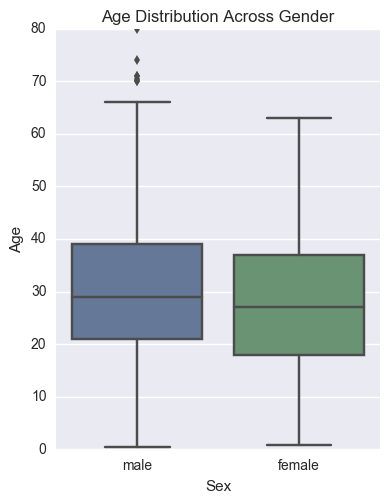

In [239]:
# graph - Age distribution by sex
g = sns.factorplot(x="Sex", y="Age", data=cleaned_titanic_df[cleaned_titanic_df.Age.notnull()], 
                   saturation=.5, kind="box", ci=None, size=5, aspect=.8)
# set titles
titles = ['Age Distribution Across Gender']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

We can see that female passengers are slightly younger than male passengers, and that all outliers we see earlier are appeared to be from male passengers. 

##### Talone

Number of missing values: 0


,count,percentage
Talone,,
False,354,39.7
True,537,60.3


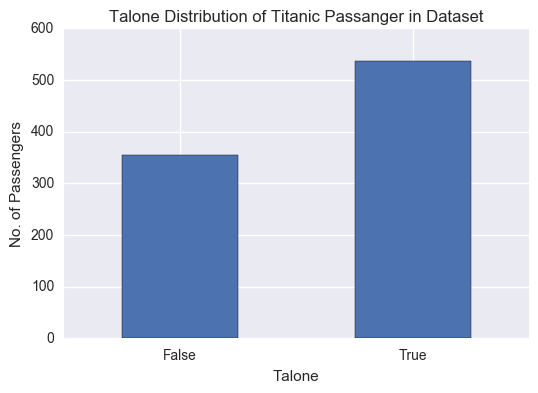

In [240]:
cleaned_titanic_bargraph('Talone')
cleaned_titanic_dist('Talone')

There's no incorrect and no missing values in Talone column. The numbers show that most passangers (60.3%) were traveling without any family member.

# Data Exploration and Visualization

Let's explore our data. First, we'll create a new Pandas DataFrame to store cleaned data.

In [241]:
# store data into new dataframe named data
data = cleaned_titanic_df

###### Data Dictionary of Cleaned Dataset

Variable      | Definition                                | Key
------------- | ------------------------------------------|------------------------------------------------
Survived      | Survival                                  | False = Not survived, True = Survived
Pclass        | Ticket Class                              | 1 = 1st, 2 = 2nd, 3 = 3rd
Sex           | Sex                                       |
Age           | Age in years                              |
Talone        | Traveling Alone                           | False = Travel with at least one family member, True = Travel Alone
AgeGroup      | Age Group                                 | Child = 17 or younger, Adult = older than 17

##### Data Limitation and Assumption

* The dataset only containts records from 891 passengers out of 2224 passengers and crew aboard the Titanic.
* We assume that the sampling method was simple random sampling.
* Some values are missing for Age and AgeGroup categories and will be ignored when dealing with these categories.

##### Overall Survival Rate

In [242]:
print "overall survival rate = {}%".format((data[['Survived']].unstack().mean()*100).round(2))

overall survival rate = 38.38%


This is going to be our reference rate when comparing whether in a particular circumstance the survival rate was higher or lower.

In [243]:
# calculate the survival count and survival rate
def survival_summary(dt, group):
    """
    Args:
        dt: data
        group: list of columns to use
    Returns:
        panda dataframe consist of survival count and percentage
    """
    
    count = dt.groupby(group).size().unstack()
    percentage = dt.groupby(group[:-1])[['Survived']].mean()

    return pd.DataFrame(data={'# survived=0':count[0], '# survived=1':count[1], 'survival rate': percentage['Survived']})

Let's start investigating.

## Q1: Did female passanger have a better chance of survival than male?

Now let's investigate the survival rate between male and female passengers and see whether female passengers were morelikely to survive than male passengers.

,# survived=0,# survived=1,survival rate
Sex,,,
female,81,233,0.742038
male,468,109,0.188908


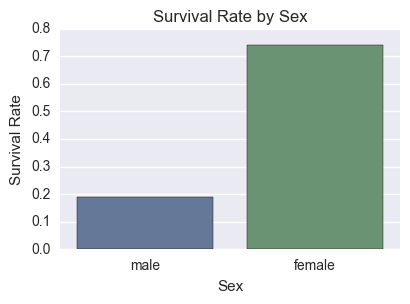

In [244]:
# graph - survival rate by sex
g = sns.factorplot(x="Sex", y="Survived", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Sex', 'Survival Rate')

# set titles
titles = ['Survival Rate by Sex']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# summary - survival rate by sex
survival_summary(data, ['Sex', 'Survived'])

We can see that roughly 74.204% female passengers in the dataset survived, but only 18.891% male passengers did. Let's see the number across socio-economic status. Tentatively, we can say that female passengers had a better chance of survival than overall passengers, while male passengers had a lower chance of survival than overall passengers, which means females were more likely to survive than male passengers.

# survived=0  # survived=1  survival rate
Pclass Sex                                              
1      female             3            91       0.968085
       male              77            45       0.368852
2      female             6            70       0.921053
       male              91            17       0.157407
3      female            72            72       0.500000
       male             300            47       0.135447

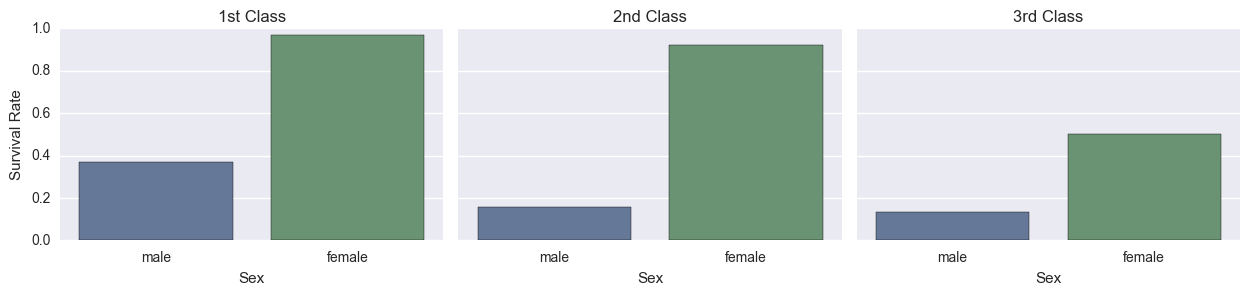

In [245]:
# graph - survival rate by sex across socio-economic status 
g = sns.factorplot(x="Sex", y="Survived", col="Pclass", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Sex', 'Survival Rate')
plt.subplots_adjust(top=0.9)

# set titles
titles = ['1st Class', '2nd Class', '3rd Class']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    
# summary - survival rate by sex across socio-economic status
survival_summary(data, ['Pclass', 'Sex', 'Survived'])

Now we can see that even across socio-economic status, female passengers were more likely to survive compare to male passengers from the same socio-economic status. Let's dig deeper and see how the numbers do across socio-economic and travel type (whether a passenger was traveling with at least one family member or not).

# survived=0  # survived=1  survival rate
Pclass Talone Sex                                              
1      False  female             2            58       0.966667
              male              27            20       0.425532
       True   female             1            33       0.970588
              male              50            25       0.333333
2      False  female             3            41       0.931818
              male              26            10       0.277778
       True   female             3            29       0.906250
              male              65             7       0.097222
3      False  female            49            35       0.416667
              male              68            15       0.180723
       True   female            23            37       0.616667
              male             232            32       0.121212

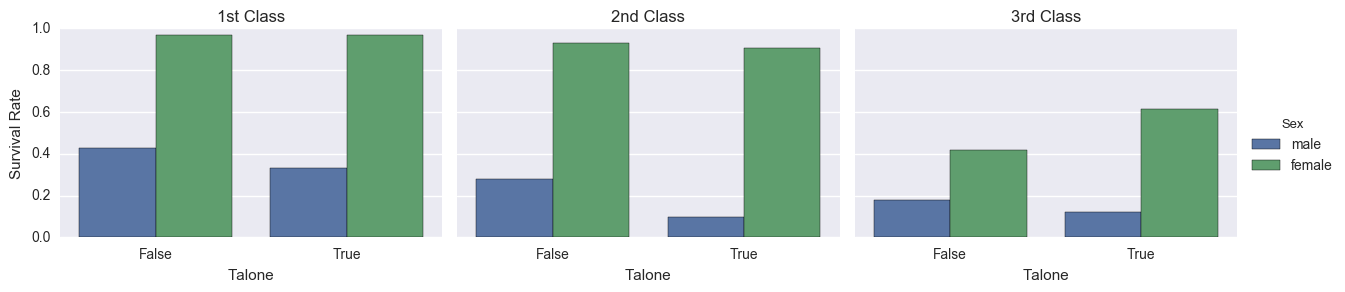

In [246]:
# graph - survival rate by Sex across socio-economic status and Talone
g = sns.factorplot(x = 'Talone', y='Survived', col='Pclass', hue='Sex'
                   , ci=None, data=data, kind='bar', size=3, aspect=1.4)

#set labels
(g.set_axis_labels('Talone', 'Survival Rate'))

# set titles
titles = ['1st Class', '2nd Class', '3rd Class']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    
# summary - survival rate by Sex across socio-economic status and Talone
survival_summary(data, ['Pclass', 'Talone', 'Sex', 'Survived'])

It does also seem that female passengers were more likely to survived the sinking Titanic than male passengers from the same class and the same traveling status (whether traveling alone or not). Even the lowest survival rate for female passengers where Pclass = 3 and Talone = 0 with survival rate 41.7%, is just slightly lower than the highest survival rate for male passengers where Pclass = 1 and Talone =0 with survival rate 42.6%. 

Therefore, we conclude that a female passenger, regardless of socio-economic and traveling status, were more likely to survive than a male passangers.

## Q2: Did socio-economic status count as a factor in survival rate?

Now let's investigate the survival rate across socio-economic status and see passengers from which socio-economic status were more likely to survive.

,# survived=0,# survived=1,survival rate
Pclass,,,
1,80,136,0.629630
2,97,87,0.472826
3,372,119,0.242363


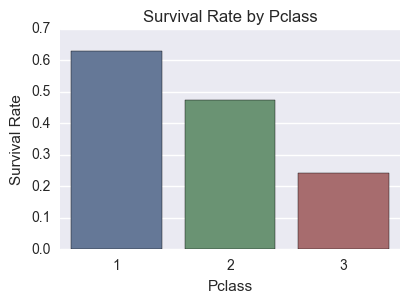

In [247]:
# graph - survival rate by socio-economic status
g = sns.factorplot(x="Pclass", y="Survived", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Pclass', 'Survival Rate')

# set titles
titles = ['Survival Rate by Pclass']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# summary - survival rate by socio-economic status
survival_summary(data, ['Pclass', 'Survived'])

Raw numbers and graph above suggest that in general, First Class passengers seems to had a higher chance of survival than Second Class passengers, and that Second Class passengers had a higher chance of survival than Third Class passengers.

First and second class passengers with survival rate of 62.96% and 47.28% respectively, had a better chance of survival than overall passengers. Third class passengers with survival rate of 24.36% had a lower chance of survival than overall passengers.

Numbers suggest that socio-economic status was a factor that determine the chance of survival.

Let's see how socio-economic status do across gender.

# survived=0  # survived=1  survival rate
Sex    Pclass                                           
female 1                  3            91       0.968085
       2                  6            70       0.921053
       3                 72            72       0.500000
male   1                 77            45       0.368852
       2                 91            17       0.157407
       3                300            47       0.135447

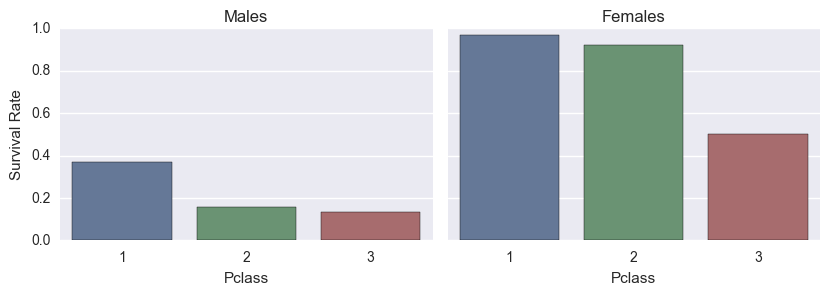

In [248]:
# graph - survival rate by socio-economic status across gender
g = sns.factorplot(x="Pclass", y="Survived", col="Sex", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Pclass', 'Survival Rate')
plt.subplots_adjust(top=0.9)

# set titles
titles = ['Males', 'Females']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# summary - survival rate by socio-economic status across gender
survival_summary(data, ['Sex', 'Pclass', 'Survived'])

It seems that among male passengers, socio-economic status played a role in a way that upper class passengers had a higher likelihood to survive (survival rate = 36.9%) than middle and lower class passengers. There seems to be only a slight difference between the survival rate of middle (15.7%) and lower (13.5%) class male passengers, that it could just be by chance. 

Among female passengers, socio-economic status played a role in determining the likelihood of survival in such a way that upper and middle class passengers had a higher chance of survival of 96.8% and 92.1% respectively, than lower class passengers (50.0%). There seems to be only a slight difference between upper and middle class female passangers survival rate, and it could also be just by chance.

Now let's dig deeper and see how it does across Talone.

# survived=0  # survived=1  survival rate
Sex    Talone Pclass                                           
female False  1                  2            58       0.966667
              2                  3            41       0.931818
              3                 49            35       0.416667
       True   1                  1            33       0.970588
              2                  3            29       0.906250
              3                 23            37       0.616667
male   False  1                 27            20       0.425532
              2                 26            10       0.277778
              3                 68            15       0.180723
       True   1                 50            25       0.333333
              2                 65             7       0.097222
              3                232            32       0.121212

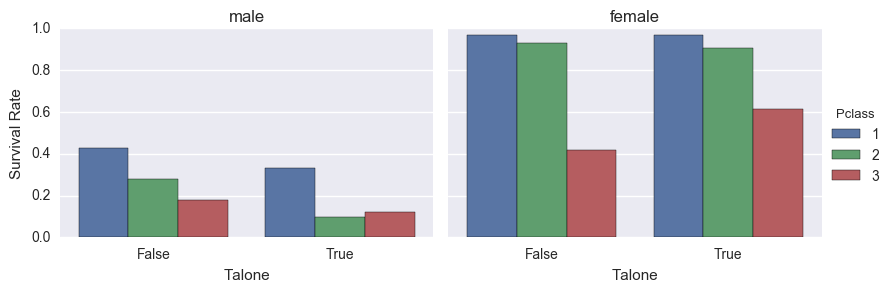

In [249]:
# graph - survival rate by socio-economic status across gender and Talone
g = sns.factorplot(x = 'Talone', y='Survived', col='Sex', hue='Pclass'
                   , ci=None, data=data, kind='bar', size=3, aspect=1.4)

#set labels
(g.set_axis_labels('Talone', 'Survival Rate'))

# set titles
titles = ['male', 'female']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# summary - survival rate by socio-economic status across gender and Talone
survival_summary(data, ['Sex', 'Talone', 'Pclass', 'Survived'])

Raw numbers and graph above amplify previous finding regarding socio-economic effect on survival rate of the passengers. No matter if they were traveling or not, female passengers in first and second class had a better chance of survival than those in third class. Also, no matter if they were traveling or not, male passengers in first class had a better chance of survival than those in second and third class. 

It is worth noting though, male passengers in second class who were traveling with at least one family members seems to have a better likelihood to survive than male passengers who were also traveling alone but from lower socio-economic status. This wasn't clear in the previous graph because the numbers for passengers traveling alone and not traveling alone was combined together.

## Q3: Did traveling alone (without family members: parents, spouse, children, or siblings) give a passanger a better chance at survival?

Now let's investigate the survival rate between those passengers who were traveling alone and those who were not, and see whether traveling alone gave a passenger a better chance of survival.

,# survived=0,# survived=1,survival rate
Talone,,,
False,175,179,0.505650
True,374,163,0.303538


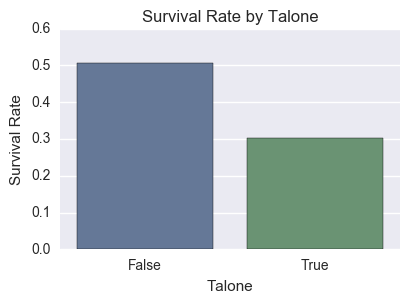

In [250]:
# graph - survival rate by Talone
g = sns.factorplot(x="Talone", y="Survived", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Talone', 'Survival Rate')

# set titles
titles = ['Survival Rate by Talone']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)


# summary - survival rate by Talone
survival_summary(data, ['Talone', 'Survived'])

It seems that traveling alone didn't give a passanger a better chance at survival, in fact numbers and graph above suggest that the opposite is true. A passenger who traveled with at least one family member seems to had a better chance of survival at 50.565% than overall passengers, and a passenger who traveled alone (30.354%) had a lower chance of survival than overall passengers. Let's see if this pattern holds accross socio-economic statuses. 

# survived=0  # survived=1  survival rate
Pclass Talone                                           
1      False             29            78       0.728972
       True              51            58       0.532110
2      False             29            51       0.637500
       True              68            36       0.346154
3      False            117            50       0.299401
       True             255            69       0.212963

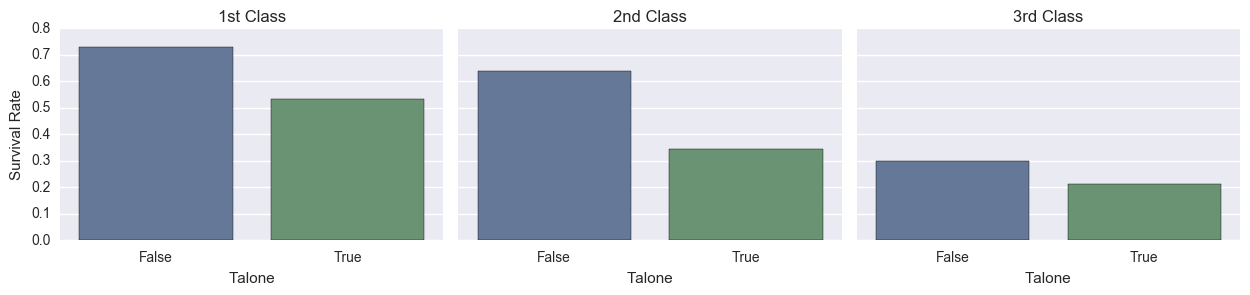

In [251]:
# graph - survival rate by Talone across socio-economic status
g = sns.factorplot(x="Talone", y="Survived", col="Pclass", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Talone', 'Survival Rate')
plt.subplots_adjust(top=0.9)

# set titles
titles = ['1st Class', '2nd Class', '3rd Class']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    
# summary - survival rate by Talone across socio-economic status
survival_summary(data, ['Pclass', 'Talone', 'Survived'])

Indeed it does. In all three classes, passengers who traveled with at least one family member seem to had a higher survival rate than those who traveled alone. Now let's see how it appears accross gender. 

# survived=0  # survived=1  survival rate
Pclass Sex    Talone                                           
1      female False              2            58       0.966667
              True               1            33       0.970588
       male   False             27            20       0.425532
              True              50            25       0.333333
2      female False              3            41       0.931818
              True               3            29       0.906250
       male   False             26            10       0.277778
              True              65             7       0.097222
3      female False             49            35       0.416667
              True              23            37       0.616667
       male   False             68            15       0.180723
              True             232            32       0.121212

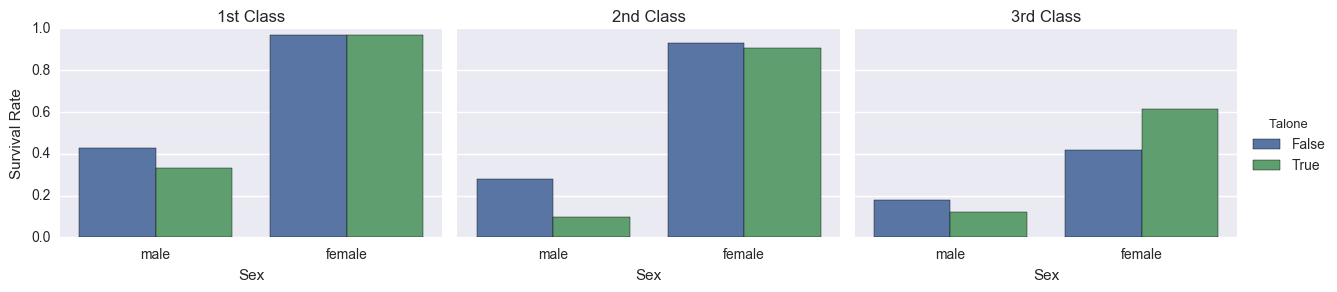

In [252]:
# graph - survival rate by Talone across socio-economic status and gender
g = sns.factorplot(x = 'Sex', y='Survived', col='Pclass', hue='Talone'
                   , ci=None, data=data, kind='bar', size=3, aspect=1.4)

#set labels
(g.set_axis_labels('Sex', 'Survival Rate'))

# set titles
titles = ['1st Class', '2nd Class', '3rd Class']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

# summary - survival rate by Talone across socio-economic status and gender
survival_summary(data, ['Pclass', 'Sex', 'Talone', 'Survived'])

This is interesting. Notice how the bar graph for male depicting that no matter which class a male passenger was in, his survival rate was higher if he was traveling with at least one family member. The largest survival rate difference between male passengers who were traveling with family member and those who were not, appears in 2nd class male passengers, with survival rate of 28.8% and 9.7% respectively.

Female passengers didn't quite follow the pattern we found in male passengers in regard to traveling alone, especiall for upper and middle class female passengers. Numbers show that no matter if they traveled with family or not, female passengers in first and second class seems to had the same likelihood to survive. But that is not the case for lower class female passengers, it seems that they had a better chance at survival if they were traveling without any family member.

Base on numbers and graphs, we can say that traveling alone did not give a passanger of Titanic a better chance at survival. The opposite seems to be true for male passengers regardless of his socio-economic status. Traveling alone or not didn't seem to affect female passangers chance of survival except for those in third class. A female passenger in third class had a better chance at survival when she traveled alone.  

## Q4: Did children (17 year-old or younger) have a better chance of survival?

Now let's investigate the survival rate between children and adults, and see whether children had a better chance of survival than adults.

,# survived=0,# survived=1,survival rate
AgeGroup,,,
Adult,355,220,0.382609
Child,69,70,0.503597


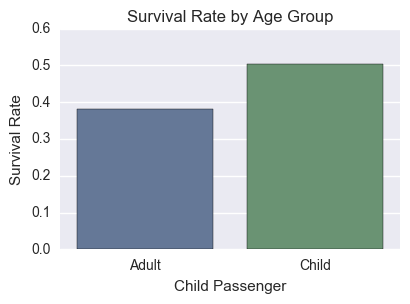

In [253]:
# graph - survival rate by ChildP
g = sns.factorplot(x="AgeGroup", y="Survived", data=data[data.Age.notnull()], 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Child Passenger', 'Survival Rate')

# set titles
titles = ['Survival Rate by Age Group']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)


# summary - survival rate by ChildP
survival_summary(data[data.Age.notnull()], ['AgeGroup', 'Survived'])

It does seems that children were more likely to survive than adult passengers with survival rate of 53.98% and 38.10% respectively. But we can also see that children were only 20% of the total passengers with age values. Let see children and adult distribution across socio-economic status.

# survived=0  # survived=1  survival rate
Pclass AgeGroup                                           
1      Adult               62           108       0.635294
       Child                2            14       0.875000
2      Adult               84            60       0.416667
       Child                6            23       0.793103
3      Adult              209            52       0.199234
       Child               61            33       0.351064

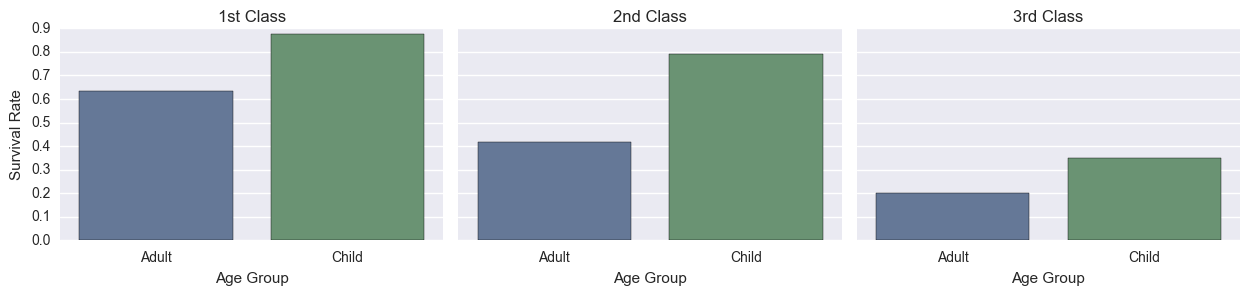

In [254]:
# graph - survival rate by ChildP across socio-economic status
g = sns.factorplot(x="AgeGroup", y="Survived", col="Pclass", data=data, 
                   saturation=.5, kind="bar", ci=None, size=3, aspect=1.4)

# set labels
g.set_axis_labels('Age Group', 'Survival Rate')
plt.subplots_adjust(top=0.9)

# set titles
titles = ['1st Class', '2nd Class', '3rd Class']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)
    
# summary - survival rate by ChildP across socio-economic status
survival_summary(data, ['Pclass', 'AgeGroup', 'Survived'])

Numbers and graphs above implify our previous finding. Across socio-economic status, children were more likely to survive compare to adult from the same socio-economic status.

# Testing & Conclusion

Base on our analysis during exploration process, we can draw a tentative conclusion that gender, socio-economic status, travel as family, and age group did affect the chance of survival of Titanic passengers. Now we need to test whether the survival outcome of the passenger was dependent on each of these characteristics.

## Statistical Testing

### Gender

##### Hypothesis
Null Hypothesis ($H_0$): survival outcome and the gender of the Titanic passengers are independent of each other

Alternative Hypothesis ($H_a$): survival outcome and the gender of the Titanic passengers are dependent

##### Analysis Plan
For this analysis, the significant level is 0.01. Since the two variables under study are categorical and the expected frequency count is more than 5, assuming that the sampling method was simple random sampling, then it is appropriate to perform chi-square test for independence.  

##### Chi-Square Analysis

In [255]:
# observed values
obs = data.groupby(['Sex', 'Survived']).size().unstack()

# chi-square test for independence
chi2, p, dof, expected = chi2_contingency(obs)

print "chi-square test statistic (df={}) = {}".format(dof,chi2)
print "p-value = {}".format(p)

chi-square test statistic (df=1) = 260.717020167
p-value = 1.19735706278e-58


##### Result
Since the p-value (0.00) is less than significant level (0.01), we reject the null hypothesis. Thus, we conclude that there is a relationship between gender and survival outcome of the Titanic passengers. 

### Socio-economic Status

##### Hypothesis
Null Hypothesis ($H_0$): survival outcome and the socio-economic status of the Titanic passengers are independent of each other

Alternative Hypothesis ($H_a$): survival outcome and the socio-economic status of the Titanic passengers are dependent

##### Analysis Plan
For this analysis, the significant level is 0.01. Since the two variables under study are categorical and the expected frequency count is more than 5, assuming that the sampling method was simple random sampling, then it is appropriate to perform chi-square test for independence.  

##### Chi-Square Analysis

In [256]:
# observed values
obs = data.groupby(['Pclass', 'Survived']).size().unstack()

# chi-square test for independence
chi2, p, dof, expected = chi2_contingency(obs)

print "chi-square test statistic (df={}, N={}) = {}".format(dof, 891, chi2)
print "p-value = {}".format(p)

chi-square test statistic (df=2, N=891) = 102.888988757
p-value = 4.5492517113e-23


##### Result

Since the p-value (0.00) is less than significant level (0.01), we reject the null hypothesis. Thus, we conclude that there is a relationship between socio-economic status and survival outcome of the Titanic passengers. 

### Traveling Alone

##### Hypothesis
Null Hypothesis ($H_0$): survival outcome and traveling alone status of the Titanic passengers are independent of each other

Alternative Hypothesis ($H_a$): survival outcome and traveling alone status of the Titanic passengers are dependent

##### Analysis Plan
For this analysis, the significant level is 0.01. Since the two variables under study are categorical and the expected frequency count is more than 5, assuming that the sampling method was simple random sampling, then it is appropriate to perform chi-square test for independence.  

##### Chi-Square Analysis

In [257]:
# observed values
obs = data.groupby(['Talone', 'Survived']).size().unstack()

# chi-square test for independence
chi2, p, dof, expected = chi2_contingency(obs)

print "chi-square test statistic (df={}) = {}".format(dof,chi2)
print "p-value = {}".format(p)

chi-square test statistic (df=1) = 36.0005144677
p-value = 1.97265438465e-09


##### Result
Since the p-value (0.00) is less than significant level (0.01), we reject the null hypothesis. Thus, we conclude that there is a relationship between traveling alone status and survival outcome of the Titanic passengers. 

### Age Group

##### Hypothesis
Null Hypothesis ($H_0$): survival outcome and age group (child or adult) status of the Titanic passengers are independent of each other

Alternative Hypothesis ($H_a$): survival outcome and age group (child or adult) status of the Titanic passengers are dependent

##### Analysis Plan
For this analysis, the significant level is 0.05. Since the two variables under study are categorical and the expected frequency count is more than 5, assuming that the sampling method was simple random sampling, then it is appropriate to perform chi-square test for independence.  

##### Chi-Square Analysis
Remember that we have missing values for Age, so we have to slice the data to consider only those with age values.

In [258]:
# observed values
obs = data[data.AgeGroup.notnull()].groupby(['AgeGroup', 'Survived']).size().unstack()

# chi-square test for independence
chi2, p, dof, expected = chi2_contingency(obs)

print "chi-square test statistic (df={}) = {}".format(dof,chi2)
print "p-value = {}".format(p)

chi-square test statistic (df=1) = 6.30131105202
p-value = 0.0120648710317


##### Result
Since the p-value (0.01) is less than significant level (0.05), we reject the null hypothesis. Thus, we conclude that there is a relationship between age group status (whether a passenger was a child or an adult) and survival outcome of the Titanic passengers.

## Conclusion

* A chi-square test with significant level $\alpha = .01$ was performed and a relationship was found between gender and survival outcome of the Titanic passengers, $\chi^2(1, N=891)=260.72$, $p < .01$
* A chi-square test with significant level $\alpha = .01$ was performed and a relationship was found between socio-economic status and survival outcome of the Titanic passengers, $\chi^2(2, N=891)=102.89$, $p < .01$
* A chi-square test with significant level $\alpha = .01$ was performed and a relationship was found between traveling alone (without any family member) and survival outcome of the Titanic passengers, $\chi^2(1, N=891)=36.0$, $p < .01$
* A chi-square test with significant level $\alpha = .05$ was performed and a relationship was found between age group (children 18 years old or younger, and adult) and survival outcome of the Titanic passengers, $\chi^2(1, N=714)=6.30$, $p = .01$

## References
* http://seaborn.pydata.org/tutorial/categorical.html
* http://stackoverflow.com/questions/24789671/change-the-title-of-factor-plot-in-seaborn
* http://www.secnetix.de/olli/Python/lambda_functions.hawk
* http://www.history.com/topics/titanic
* http://www.titanicfacts.net/titanic-survivors.html
* https://www.encyclopedia-titanica.org/titanic-survivors/